# Experiments

In [3]:
import jax, jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import dill
import tqdm

from pcg_stein.distribution import BayesianLogisticRegression
from pcg_stein.kernel import Matern52Kernel, Matern72Kernel, IMQKernel, GaussianKernel
from pcg_stein.pcg import pcg
from pcg_stein.precon import Nystrom, NystromDiagonal, NystromRandom, RandomisedSVD, FITC, BlockJacobi
from pcg_stein.util import PCG_Experiment

jax.config.update("jax_enable_x64", True) # double precision


## Setup Experiments

### Assumptions
- We fix one synthetic experiment.
- Randomness over the MCMC samples from the posterior and the random preconditioner methods.


### Parameter ranges

- lengthscales are on base e scale? `jnp.logspace(-3, 1, 5, base = jnp.e)` 
- nuggets are on base 10 scale? `jnp.logspace(-4, 4, 5)`

In [4]:
from pcg_stein.registry import KERNEL_REGISTRY, PRECON_REGISTRY

KERNEL_REGISTRY

{'Matern52': pcg_stein.kernel.Matern52Kernel,
 'Matern72': pcg_stein.kernel.Matern72Kernel,
 'Gaussian': pcg_stein.kernel.GaussianKernel,
 'IMQ': pcg_stein.kernel.IMQKernel}

In [5]:
PRECON_REGISTRY

{'Nystrom': pcg_stein.precon.Nystrom,
 'NystromRandom': pcg_stein.precon.NystromRandom,
 'NystromDiagonal': pcg_stein.precon.NystromDiagonal,
 'RandomisedSVD': pcg_stein.precon.RandomisedSVD,
 'FITC': pcg_stein.precon.FITC,
 'BlockJacobi': pcg_stein.precon.BlockJacobi}

In [ ]:
kernel = Matern52Kernel()
precons = [Nystrom(), NystromDiagonal(), NystromRandom(), RandomisedSVD(), FITC(), BlockJacobi()]

synth_data_key = jax.random.key(0) # key used to generate synthetic data
n_synth_data = 1_000
true_beta = jnp.array([1.0, -2.0, 1.0, 4.0])
dist = BayesianLogisticRegression.from_synthetic(synth_data_key, n_synth_data, true_beta=true_beta)
X = dist.sample(jax.random.key(0), 1000)
Sx = dist.score(X)

stein_mat = kernel.stein_matrix(X, X, Sx, Sx)
b = jnp.ones(1000)

key = jax.random.key(1)
precons[0](key, stein_mat, nugget=1e-3, block_size=5, m=50).shape

(1000, 1000)

In [ ]:
key = jax.random.key(1)

pcg_exp = PCG_Experiment(dist, X, kernel, precons)



pcg_exp(key, precon_kwargs={'m': 50, 'nugget':1e-1, 'block_size': 5}, kernel_kwargs={'lengthscale': 1e-1})

{'Nystrom': Array(0., dtype=float64, weak_type=True),
 'Nystrom (diagonal sampling)': Array(0., dtype=float64, weak_type=True),
 'Nystrom (random projection)': Array(0., dtype=float64, weak_type=True),
 'Randomised SVD': Array(0.28768207, dtype=float64, weak_type=True),
 'FITC': Array(0., dtype=float64, weak_type=True),
 'Block Jacobi': Array(0., dtype=float64, weak_type=True)}

In [77]:
ell = 1.
stein_mat = kernel.stein_matrix(X, X, Sx, Sx, lengthscale=ell)
pcg_exp.set_reference_wce(lengthscale=ell)
wce = pcg_exp.wce
print(wce)

out_cg = pcg(stein_mat, b, wce_tol = wce * 1.01, atol=0., rtol=0., M_inv=None)

m_inv = precons[2](jax.random.key(1), stein_mat, nugget=1e-1, block_size=5, m=50)

out_pcg = pcg(stein_mat, b, wce_tol = wce * 1.01, atol=0., rtol=0., M_inv=m_inv)

print('cg iters:', out_cg[1])
print('pcg iters:' ,out_pcg[1])

0.018074998514670412
cg iters: 458
pcg iters: 65


In [78]:
out_cg = pcg(stein_mat, b, maxiter=1000, wce_tol=0., atol=0., rtol=0., M_inv=None)
out_pcg = pcg(stein_mat, b, maxiter=1000, wce_tol=0., atol=0., rtol=0., M_inv=m_inv)

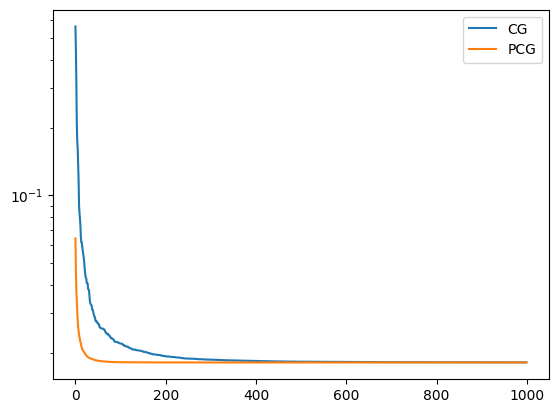

In [79]:
plt.plot(out_cg[3], label='CG')
plt.plot(out_pcg[3], label='PCG')
plt.yscale('log')
plt.legend()

In [53]:
out_pcg[1]

Array(28, dtype=int64, weak_type=True)

In [ ]:
pcg(stein_mat, b, wce_tol=0.74676366 * 1.1, M_inv=None)

In [31]:
pcg_exp.set_reference_wce(lengthscale=lengthscales[0])

In [32]:
pcg_exp.wce

Array(1.66237682, dtype=float64)

In [7]:
pcg_exp.wce

Array(0.74676366, dtype=float64)

In [29]:
lengthscales[0]

Array(0.04978707, dtype=float64)

In [33]:
X = dist.sample(jax.random.key(0), 1000)
Sx = dist.score(X)

stein_mat = kernel.stein_matrix(X, X, Sx, Sx, lengthscale=lengthscales[0])

b = jnp.ones(1000)
pcg(stein_mat, b, wce_tol=1.66237682 * 1.1, M_inv=None)

(Array([0.00033056, 0.00033056, 0.00033056, 0.00033056, 0.00033056,
        0.00033056, 0.00033056, 0.00033056, 0.00033056, 0.00033056,
        0.00033056, 0.00033056, 0.00033056, 0.00033056, 0.00033056,
        0.00033056, 0.00033056, 0.00033056, 0.00033056, 0.00033056,
        0.00033056, 0.00033056, 0.00033056, 0.00033056, 0.00033056,
        0.00033056, 0.00033056, 0.00033056, 0.00033056, 0.00033056,
        0.00033056, 0.00033056, 0.00033056, 0.00033056, 0.00033056,
        0.00033056, 0.00033056, 0.00033056, 0.00033056, 0.00033056,
        0.00033056, 0.00033056, 0.00033056, 0.00033056, 0.00033056,
        0.00033056, 0.00033056, 0.00033056, 0.00033056, 0.00033056,
        0.00033056, 0.00033056, 0.00033056, 0.00033056, 0.00033056,
        0.00033056, 0.00033056, 0.00033056, 0.00033056, 0.00033056,
        0.00033056, 0.00033056, 0.00033056, 0.00033056, 0.00033056,
        0.00033056, 0.00033056, 0.00033056, 0.00033056, 0.00033056,
        0.00033056, 0.00033056, 0.00033056, 0.00

In [11]:
m_inv = precons[0](jax.random.key(1), stein_mat, nugget=1e-1, m=50)

pcg(stein_mat, b, wce_tol=0.74676366 * 1.1, M_inv=m_inv)[3]

Array([0.05920149], dtype=float64)

In [34]:
stein_mat = kernel.stein_matrix(X, X, Sx, Sx, lengthscale = lengthscales[0])
out = pcg(stein_mat, b, wce_tol=0., maxiter=10000, M_inv=None, rtol=0., atol=0.)

In [36]:
out[3]

Array([1.73930032, 1.67140446, 1.66377101, ..., 1.66237682, 1.66237682,
       1.66237682], dtype=float64)

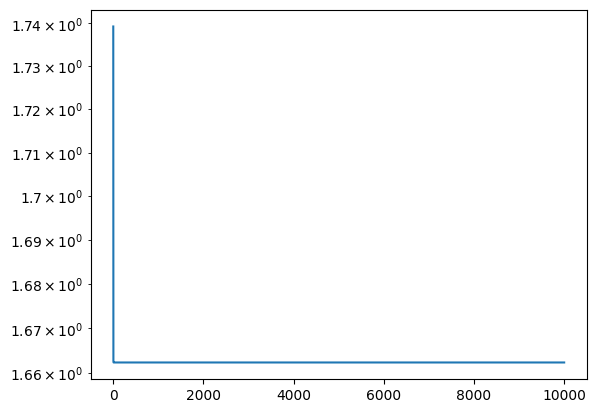

In [35]:
plt.plot(out[3])
plt.yscale('log')

In [ ]:
kernel = Matern52Kernel()
precons = [NystromWoodbury(), NystromRandomDiagonalWoodbury(), NystromRandomWoodbury(), RandomisedSVD(), FITC(), BlockJacobi()]

synth_data_key = jax.random.key(0) # key used to generate synthetic data
n_synth_data = 1_000
true_beta = jnp.array([1.0, -2.0, 1.0, 4.0])
dist = BayesianLogisticRegression.from_synthetic(synth_data_key, n_synth_data, true_beta=true_beta)

# Define preconditioner parameters
block_sizes = [1] # block sizes to use in BlockJacobi
nuggets = jnp.logspace(-4, 4, 1, base=10) # Woodbury inverse nuggets - could use jnp.logspace(-4, 4, 4)
m = 50 # target rank of approximation

# Define kernel parameters
lengthscales = jnp.logspace(-3, 1, 1, base=jnp.e)

# Define Experiment Variables
num_replicates = 2 # number of repeated experiments 
n = 1_000 # number of MCMC samples to be generated
keys = [jax.random.key(1), jax.random.key(2)] # [key for MCMC sampling, key for preconditioner]

def run_experiments(kernel, precons, keys, block_sizes, nuggets, lengthscales, m=m, num_replicates=num_replicates, n=n, wce_mul=1.01):
    assert len(block_sizes) == len(nuggets)
    
    sample_key, precon_key = keys

    results = []

    for r in range(num_replicates):
        sample_key, _ = jax.random.split(sample_key, 2)
        dist_sample_r = dist.sample(sample_key, n)
        for i in range(len(lengthscales)):
            kernel_kwargs = {'lengthscale': lengthscales[i]}
            pcg_experiment = PCG_Experiment(dist, dist_sample_r, kernel, precons)
            pcg_experiment.set_reference_wce(**kernel_kwargs)

            for j in range(len(block_sizes)):
                precon_kwargs = {'block_size': block_sizes[i], 'nugget': nuggets[i], 'm': m}
                experiment_out = pcg_experiment(precon_key, wce_mul=wce_mul, kernel_kwargs=kernel_kwargs, precon_kwargs=precon_kwargs)
                result = {'out': experiment_out, 'kernel_kwargs':kernel_kwargs, 'precon_kwargs': precon_kwargs}
                results.append(result)
    
    return results


run_experiments(kernel, precons, keys, block_sizes, nuggets, lengthscales, m=m, num_replicates=2, n=n, wce_mul=1.1)





[{'out': {'Nystrom': Array(0., dtype=float64, weak_type=True),
   'Nystrom (diagonal sampling)': Array(0., dtype=float64, weak_type=True),
   'Nystrom (random projection)': Array(0., dtype=float64, weak_type=True),
   'Randomised SVD': Array(0., dtype=float64, weak_type=True),
   'FITC': Array(0., dtype=float64, weak_type=True),
   'Block Jacobi': Array(0., dtype=float64, weak_type=True)},
  'kernel_kwargs': {'lengthscale': Array(0.04978707, dtype=float64)},
  'precon_kwargs': {'block_size': 1,
   'nugget': Array(1.e-04, dtype=float64),
   'm': 50}},
 {'out': {'Nystrom': Array(0., dtype=float64, weak_type=True),
   'Nystrom (diagonal sampling)': Array(0., dtype=float64, weak_type=True),
   'Nystrom (random projection)': Array(0., dtype=float64, weak_type=True),
   'Randomised SVD': Array(0., dtype=float64, weak_type=True),
   'FITC': Array(0., dtype=float64, weak_type=True),
   'Block Jacobi': Array(0., dtype=float64, weak_type=True)},
  'kernel_kwargs': {'lengthscale': Array(0.0497870

In [ ]:
NystromRandomWoodbury()(jnp.eye(10), )

(Array([[1., 0.],
        [0., 1.]], dtype=float64),
 Array([[1., 0.],
        [0., 1.],
        [0., 0.],
        [0., 0.]], dtype=float64),
 Array([[1., 0., 0., 0.],
        [0., 1., 0., 0.]], dtype=float64))

In [ ]:
jnp.logspace()